In [2]:
#importing the libraries and reading the data
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random


In [3]:
#reading the data
df = pd.read_csv('spotify_Song_Dataset/dataset.csv')

#removing the row with null values
df = df.dropna()

#dropping duration and explicit columns 
df = df.drop(['duration_ms','explicit','mode','liveness','loudness','time_signature','key'],axis=1)

df.rename(columns={'Unnamed: 0': 'song_id'}, inplace=True)

print(df.columns)

df.head(5)


Index(['song_id', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'valence', 'tempo', 'track_genre'],
      dtype='object')


,song_id,track_id,artists,album_name,track_name,popularity,danceability,energy,speechiness,acousticness,instrumentalness,valence,tempo,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,0.676,0.4610,0.1430,0.0322,0.000001,0.715,87.917,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,0.420,0.1660,0.0763,0.9240,0.000006,0.267,77.489,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,0.438,0.3590,0.0557,0.2100,0.000000,0.120,76.332,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,0.266,0.0596,0.0363,0.9050,0.000071,0.143,181.740,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,0.618,0.4430,0.0526,0.4690,0.000000,0.167,119.949,acoustic


# Correlation Matrix 

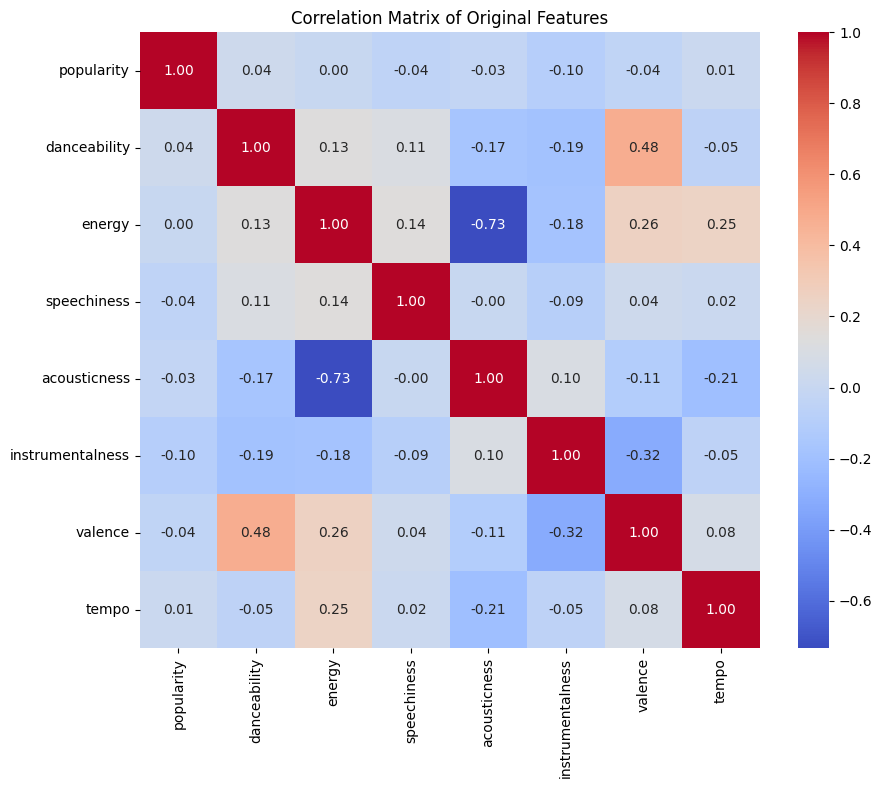

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your original DataFrame
# Select the relevant numerical features for correlation analysis
numerical_features = ['popularity', 'danceability', 'energy', 'speechiness', 
                      'acousticness', 'instrumentalness', 'valence', 'tempo']

# Calculate the correlation matrix
correlation_matrix = df[numerical_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Original Features')
plt.show()


In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import hashlib

# Function to create a unique hash for the combination of artists
def hash_artists(artists):
    artist_string = ';'.join(sorted(artists))
    return int(hashlib.sha256(artist_string.encode('utf-8')).hexdigest(), 16) % 10**8

# Keep only the continuous audio features and popularity
features_to_scale = ['popularity', 'danceability', 'energy', 'acousticness', 'valence', 'tempo']

# Scaling the continuous audio features and popularity
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features_to_scale])

# Convert the scaled features back to a DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale)

# Add the original identification and categorical columns back to the DataFrame
df_scaled['song_id'] = df['song_id']
df_scaled['track_id'] = df['track_id']
df_scaled['artist_name'] = df['artists'].fillna('')  # Fill NaN with an empty string
df_scaled['track_name'] = df['track_name']
df_scaled['album_name'] = df['album_name'].fillna('')  # Fill NaN with an empty string
df_scaled['track_genre'] = df['track_genre'].fillna('')  # Fill NaN with an empty string

# Handling artist encoding: split, hash each combination of artists
artist_split = df_scaled['artist_name'].apply(lambda x: x.split(';') if isinstance(x, str) else [])
df_scaled['artist_name_encoded'] = artist_split.apply(lambda x: hash_artists(x))

# Encoding album_name with consistent factorization
df_scaled['album_name_encoded'], _ = pd.factorize(df_scaled['album_name'])

# Encoding track_genre with consistent factorization
df_scaled['track_genre'] = df_scaled['track_genre'].astype(str)
genre_split = df_scaled['track_genre'].apply(lambda x: x.split(';') if isinstance(x, str) else [])
df_scaled['track_genre_encoded'], _ = pd.factorize(genre_split.apply(lambda x: ';'.join(sorted(x if isinstance(x, list) else [x]))))

# Recompute z-scores and handle extreme outliers (only for the continuous features)
z_scores = stats.zscore(df_scaled[features_to_scale])
outliers = (z_scores > 5) | (z_scores < -5)
df_scaled = df_scaled[(~outliers).all(axis=1)]

# Handling missing data
df_scaled = df_scaled.dropna()

# Re-scaling the continuous features after handling outliers
scaled_features = scaler.fit_transform(df_scaled[features_to_scale])
df_scaled[features_to_scale] = scaled_features

# Reordering the DataFrame columns to have song information first
df_scaled = df_scaled[['song_id', 'track_id', 'artist_name', 'track_name', 'album_name', 'track_genre', 
                       'popularity', 'energy', 'acousticness', 'valence', 'tempo', 
                       'track_genre_encoded', 'artist_name_encoded', 'album_name_encoded']]

print(df_scaled.columns)

# Display the final processed DataFrame
df_scaled.head(5)


Index(['song_id', 'track_id', 'artist_name', 'track_name', 'album_name',
       'track_genre', 'popularity', 'energy', 'acousticness', 'valence',
       'tempo', 'track_genre_encoded', 'artist_name_encoded',
       'album_name_encoded'],
      dtype='object')


,song_id,track_id,artist_name,track_name,album_name,track_genre,popularity,energy,acousticness,valence,tempo,track_genre_encoded,artist_name_encoded,album_name_encoded
0,0.0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,acoustic,1.782644,-0.717140,-0.850188,0.929311,-1.141847,0,83939727,0
1,1.0,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost - Acoustic,Ghost (Acoustic),acoustic,0.975642,-1.889963,1.831737,-0.798677,-1.489699,0,21688021,1
2,2.0,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,acoustic,1.065309,-1.122659,-0.315487,-1.365673,-1.528293,0,33756750,2
3,3.0,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Can't Help Falling In Love,Crazy Rich Asians (Original Motion Picture Sou...,acoustic,1.692977,-2.312975,1.774598,-1.276959,1.987854,0,78293893,3
4,4.0,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,acoustic,2.186145,-0.788702,0.463408,-1.184389,-0.073339,0,97979347,4


## Polynomial features 

In [20]:
print(df_scaled.info())

#duplicate values
duplicate = df_scaled.duplicated()

print(duplicate.sum())

#dropping duplicate values
df_scaled = df_scaled.drop_duplicates()


<class 'pandas.core.frame.DataFrame'>
Index: 113998 entries, 0 to 113998
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   song_id              113998 non-null  float64
 1   track_id             113998 non-null  object 
 2   artist_name          113998 non-null  object 
 3   track_name           113998 non-null  object 
 4   album_name           113998 non-null  object 
 5   track_genre          113998 non-null  object 
 6   popularity           113998 non-null  float64
 7   energy               113998 non-null  float64
 8   acousticness         113998 non-null  float64
 9   valence              113998 non-null  float64
 10  tempo                113998 non-null  float64
 11  track_genre_encoded  113998 non-null  int64  
 12  artist_name_encoded  113998 non-null  int64  
 13  album_name_encoded   113998 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 13.0+ MB
None
0


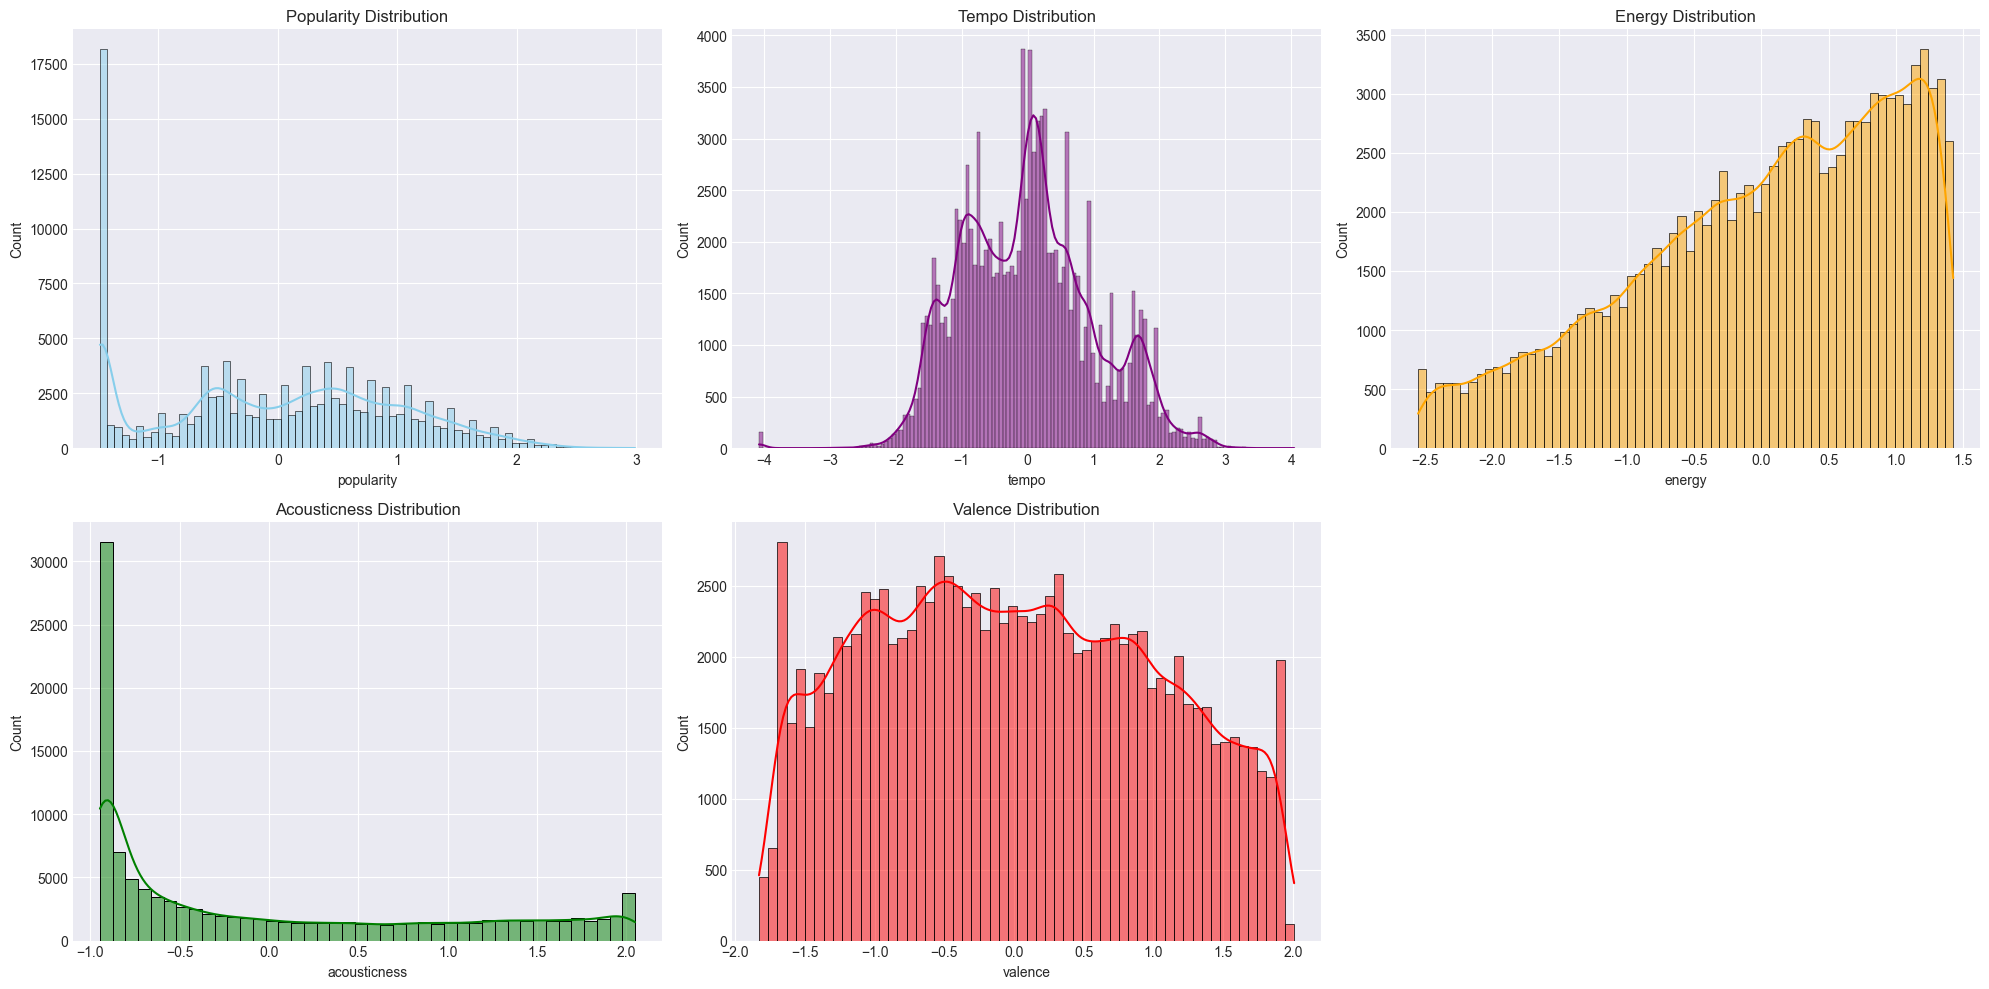

Popularity Range: -1.4901997147312063 - 2.993148091939036
Tempo Range: -4.07453780331768 - 4.043742828447413
Energy Range: -2.5499248805605244 - 1.4257471670210757
Acousticness Range: -0.9470236758572687 - 2.048264244184471
Valence Range: -1.8285270196174 - 2.0093035248973643


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distributions of the continuous features
plt.style.use('seaborn-v0_8-darkgrid')

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot the distribution of popularity
sns.histplot(df_scaled['popularity'], kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Popularity Distribution')

# Plot the distribution of tempo
sns.histplot(df_scaled['tempo'], kde=True, color='purple', ax=axes[0, 1])
axes[0, 1].set_title('Tempo Distribution')

# Plot the distribution of energy
sns.histplot(df_scaled['energy'], kde=True, color='orange', ax=axes[0, 2])
axes[0, 2].set_title('Energy Distribution')

# Plot the distribution of acousticness
sns.histplot(df_scaled['acousticness'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title('Acousticness Distribution')

# Plot the distribution of valence
sns.histplot(df_scaled['valence'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_title('Valence Distribution')

# Remove the last subplot (unused)
fig.delaxes(axes[1, 2])

# Display the plots
plt.tight_layout()
plt.show()

# Printing the range of each audio feature
print('Popularity Range:', df_scaled['popularity'].min(), '-', df_scaled['popularity'].max())
print('Tempo Range:', df_scaled['tempo'].min(), '-', df_scaled['tempo'].max())
print('Energy Range:', df_scaled['energy'].min(), '-', df_scaled['energy'].max())
print('Acousticness Range:', df_scaled['acousticness'].min(), '-', df_scaled['acousticness'].max())
print('Valence Range:', df_scaled['valence'].min(), '-', df_scaled['valence'].max())


In [22]:
#saving the final dataset
final_df = df_scaled
final_df.to_csv('spotify_Song_Dataset/final_dataset.csv',index=False)

print(final_df.columns)


Index(['song_id', 'track_id', 'artist_name', 'track_name', 'album_name',
       'track_genre', 'popularity', 'energy', 'acousticness', 'valence',
       'tempo', 'track_genre_encoded', 'artist_name_encoded',
       'album_name_encoded'],
      dtype='object')


In [ ]:
#finding all the songs inside starboy album
starboy = final_df[final_df['album_name'] == 'Starboy']
print(starboy)

#finding all the songs by the weeknd
weeknd = final_df[final_df['artist_name'] == 'The Weeknd']
print(weeknd)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Define the features for similarity calculation, excluding popularity
features = ['energy', 'acousticness', 'valence', 'tempo', 'track_genre_encoded', 'artist_name_encoded', 'album_name_encoded']

# Define the weighted importance for each feature (e.g., more weight on genre and artist)
feature_weights = {
    'energy': 1.0,
    'acousticness': 1.0,
    'valence': 1.0,
    'tempo': 1.0,
    'track_genre_encoded': 8.0,
    'artist_name_encoded': 8.0,
    'album_name_encoded': 2.0
}

def recommend_songs(user_songs, df, features, feature_weights, top_n=5):
    """
    Recommend songs based on a list of user input songs.
    """
    # Ensure that the DataFrame is copied to avoid modifying the original data
    df_copy = df.copy()

    # Apply feature weights to the selected features
    for feature in features:
        df_copy[feature] = df_copy[feature] * feature_weights[feature]
    
    # Filter the dataset to get the user's songs
    user_songs_df = df_copy[df_copy['song_id'].isin(user_songs)]
    
    # Compute cosine similarity between all songs in the dataset and the user's songs
    similarity_matrix = cosine_similarity(df_copy[features], user_songs_df[features])
    
    # Aggregate the similarity scores across all user songs
    aggregated_similarities = similarity_matrix.mean(axis=1)
    
    # Add the similarity scores to the dataframe
    df_copy['similarity'] = aggregated_similarities
    
    # Exclude the user's input songs from the recommendations
    recommendations = df_copy[~df_copy['song_id'].isin(user_songs)]
    
    # Sort by similarity score (and by popularity as a secondary sort if available)
    recommendations = recommendations.sort_values(by=['similarity', 'popularity'], ascending=[False, False])
    
    # Get the top N recommendations
    recommended_songs_df = recommendations.head(top_n)
    
    return recommended_songs_df

# Example usage:
user_songs = [67016, 91000, 81004, 17000, 20414, 81000, 81074, 81109, 20652, 91016, 91017, 91018, 51150, 51503, 56064, 33012, 57162, 53050, 67351, 51450, 94632, 51500, 53055]
recommended_songs = recommend_songs(user_songs, df_scaled, features, feature_weights, top_n=10)

#printing the user songs
print("User Songs: \n")

for song_id in user_songs:
    song = df_scaled[df_scaled['song_id'] == song_id]
    print(f"Song ID: {song_id}")
    print(f"Track Name: {song['track_name'].values[0]}")
    print(f"Artist Name: {song['artist_name'].values[0]}")
    print(f"Album Name: {song['album_name'].values[0]}\n")
    print("\n")
    

# Print the recommended songs
print("Recommended Songs: \n")
for index, row in recommended_songs.iterrows():
    print(f"Song ID: {row['song_id']}, Similarity: {row['similarity']:0.4f} \n")
    print(f"Song Details: ")
    print(f"Track Name: {row['track_name']}")
    print(f"Artist Name: {row['artist_name']}")
    print(f"Album Name: {row['album_name']}\n")
    print("\n")



User Songs: 

Song ID: 67016
Track Name: MIA
Artist Name: Bad Bunny;Drake
Album Name: Today's Party Hits



Song ID: 91000
Track Name: Sex, Drugs, Etc.
Artist Name: Beach Weather
Album Name: Chit Chat



Song ID: 81004
Track Name: Starboy
Artist Name: The Weeknd;Daft Punk
Album Name: Starboy



Song ID: 17000
Track Name: Lost in the Fire (feat. The Weeknd)
Artist Name: Gesaffelstein;The Weeknd
Album Name: Hyperion



Song ID: 20414
Track Name: Eastside (with Halsey & Khalid)
Artist Name: benny blanco;Halsey;Khalid
Album Name: FRIENDS KEEP SECRETS



Song ID: 81000
Track Name: Blinding Lights
Artist Name: The Weeknd
Album Name: After Hours



Song ID: 81074
Track Name: The Hills
Artist Name: The Weeknd
Album Name: Drippy Drippy



Song ID: 81109
Track Name: After Hours
Artist Name: The Weeknd
Album Name: Halloween Party 2022



Song ID: 20652
Track Name: Gimme More
Artist Name: Britney Spears
Album Name: Blackout



Song ID: 91016
Track Name: Whatever It Takes
Artist Name: Imagine Drago

# VADER SENTIMENT ANALYSIS

In [12]:
def analyze_user_emotion(user_text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(user_text)
    
    # Determine the emotion based on the sentiment scores
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

### Environment for the reinforcement learning model

In [14]:
def recommend_songs_based_on_emotion(user_songs, df, features, user_emotion, top_n=20):
    """
    Recommend songs considering user's emotional state.
    """
    
    # Get the cosine similarity-based recommendations
    recommended_songs = recommend_songs(user_songs, df, features, top_n)
    
    # Incorporate the user's emotion into the recommendation strategy
    # For simplicity, assume we have predefined weights for each emotion
    emotion_weights = {
        'positive': 1.0,
        'neutral': 0.5,
        'negative': -1.0
    }
    
    # Adjust the similarity score based on emotion
    recommended_songs['adjusted_similarity'] = recommended_songs['similarity'] * emotion_weights[user_emotion]
    
    # Sort again based on the adjusted similarity
    recommended_songs = recommended_songs.sort_values(by='adjusted_similarity', ascending=False)
    
    return recommended_songs.head(top_n)


Not bad I am feeling good but a little worried about some stuff but I guess it will get better soon

In [17]:
import numpy as np
import random
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

class RecommendationAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.q_table = np.zeros((state_size, action_size))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore: random song
        return np.argmax(self.q_table[state])  # Exploit: best known song

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return  # Do nothing if not enough samples in memory
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.max(self.q_table[next_state])
            self.q_table[state, action] += self.learning_rate * (target - self.q_table[state, action])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Example usage
state_size = 3  # Three possible emotions: positive, neutral, negative
action_size = len(df_scaled)  # Number of songs in the dataset

# Initialize the RL agent
agent = RecommendationAgent(state_size, action_size)

# Initialize the user_songs playlist with some initial songs
user_songs = [910433, 67016, 91000, 81004, 17000, 20414, 81000, 81074, 81109, 20652, 91016, 91017, 91018, 51150, 51503, 56064, 33012, 57162, 53050, 67351, 51450, 94632, 51500, 53055]

# Interactive loop for user interaction
for e in range(10):  # Number of interactions (can be adjusted)
    # Get user input for emotion analysis
    user_text = input("How are you feeling today? ")
    user_emotion = analyze_user_emotion(user_text)
    state = ['positive', 'neutral', 'negative'].index(user_emotion)
    
    # RL agent decides which song to recommend based on the current state (emotion)
    action = agent.act(state)
    
    # Get the top N recommendations based on the selected song and user emotion
    recommended_songs = recommend_songs_based_on_emotion(user_songs=user_songs, df=df_scaled, features=features, user_emotion=user_emotion, top_n=20)
    
    # Occasionally recommend a random song from the dataset to introduce new interests
    if np.random.rand() < 0.1:  # 10% chance to recommend a random song
        random_action = random.randrange(action_size)
        print(f"Exploration Recommendation (Random Song): {df_scaled.iloc[random_action]['track_name']} by {df_scaled.iloc[random_action]['artist_name']}")
    
    # Show the recommendations to the user and get feedback for each song
    print("Top 20 Recommendations based on your current mood:")
    for index, row in recommended_songs.iterrows():
        print(f"{row['track_name']} by {row['artist_name']} (Similarity: {row['adjusted_similarity']:0.4f})")
        feedback = input("Did you like this recommendation? (yes/no): ")
        reward = 1 if feedback.lower() == "yes" else -1
        
        # If the song is liked, ask if the user wants to add it to their playlist
        if reward == 1:
            add_to_playlist = input("Would you like to add this song to your playlist? (yes/no): ")
            if add_to_playlist.lower() == "yes":
                user_songs.append(row.name)
        
        # Simulate the next state: how the user's emotion changes after interacting with the recommendation
        next_state = np.random.randint(0, state_size)
        done = False  # The episode continues indefinitely
        
        # Store the experience in the agent's memory
        agent.remember(state, row.name, reward, next_state, done)
    
    # Train the agent with replay (experience replay)
    agent.replay(batch_size=32)
    
    #print the user songs
    print("\nYour Playlist:", user_songs)
    print("Your Playlist:")
    for song_id in user_songs:
        song_details = df_scaled[df_scaled['song_id'] == song_id].iloc[0]
        print(f"{song_details['track_name']} by {song_details['artist_name']}")

    print("\n--- End of Interaction ---\n")


Top 20 Recommendations based on your current mood:
Gol by Malt (Similarity: 0.9986)
Cold Little Heart by Michael Kiwanuka (Similarity: 0.9986)
Alone for Christmas by Ty Dolla $ign;Kiana Ledé (Similarity: 0.9986)
Ego Death by Ty Dolla $ign;Kanye West;FKA twigs;Skrillex (Similarity: 0.9986)
when we were 16 by Rxseboy;Powfu;Mishaal (Similarity: 0.9986)
Laurel Canyon Night Drive - Jody Wisternoff Extended Breaking Sticks Remix by BT;Jody Wisternoff (Similarity: 0.9986)
Hola by Serhat Durmus (Similarity: 0.9986)
Rest Of Our Lives by Ben Gold (Similarity: 0.9986)
28 Reasons by SEULGI (Similarity: 0.9986)
Vesúvio by Djavan (Similarity: 0.9986)
Vatten by Robert Broberg (Similarity: 0.9986)
China by Anuel AA;Daddy Yankee;KAROL G;J Balvin;Ozuna (Similarity: 0.9986)
Risk by Motive (Similarity: 0.9986)
The Long Way by Avanti Nagral (Similarity: 0.9986)
Kendimce by Sezen Aksu (Similarity: 0.9986)
Kuytu Köşelerde by Şanışer (Similarity: 0.9986)
fanus by Mavi;Defa (Similarity: 0.9986)
Te Assumo - Ao 

IndexError: single positional indexer is out-of-bounds